# Build processing workflow

In [3]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xrsignal as xrs
import kaooi
import os

from dask.distributed import Client

%load_ext autoreload 
%autoreload 2

In [4]:
client = Client()
client

2024-01-10 22:17:13,675 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-bo0m0baz', purging
2024-01-10 22:17:13,676 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-yti8stok', purging
2024-01-10 22:17:13,676 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-mkrthlkp', purging
2024-01-10 22:17:13,676 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-5lvke40n', purging
2024-01-10 22:17:13,676 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-x5ysvx1o', purging
2024-01-10 22:17:13,676 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-6t8pw8wb', purging
2024-01-10 22:17:13,677 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-5xdn8gq8', purging

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 62.79 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44531,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 62.79 GiB
Comm: tcp://127.0.0.1:38705,Total threads: 4
Dashboard: http://127.0.0.1:38597/status,Memory: 7.85 GiB
Nanny: tcp://127.0.0.1:36791,


In [5]:
fdir = '/datadrive/kauai/transmissions/ooi_bb/LJ01C/'
fns = os.listdir(fdir)

fs = []
for k, f in enumerate(fns):
    fs.append(f'{fdir}{f}')
    if k == 10:
        break


In [6]:
ds = xr.open_mfdataset(fs)

In [7]:
std = ds.std('time')

In [8]:
ds_clip = ds.clip(-5*std, 5*std)

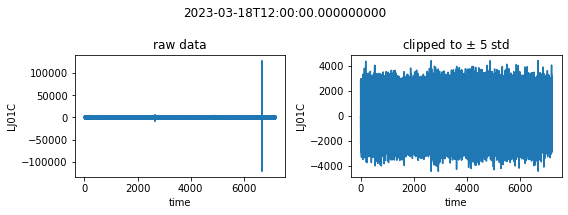

In [7]:
k = 3

fig = plt.figure(figsize=(8,3))
fig.suptitle(ds.transmission[k].values)
plt.subplot(1,2,1)
ds['LJ01C'][:,k].plot()
plt.title('raw data')

plt.subplot(1,2,2)
ds_clip['LJ01C'][:,k].plot()
plt.title('clipped to $\pm$ 5 std')
plt.tight_layout()

In [9]:
rep = kaooi.construct_replica(500)

**Why does correlate compute when you call it?**

In [11]:
ds_match = xrs.correlate(ds_clip['LJ01C'], rep, mode='full')

In [10]:
ds_match

<xarray.DataArray 'correlated data' (time: 3613640, transmission: 11)>
dask.array<<this-array>-correlate_chunk, shape=(3613640, 11), dtype=float64, chunksize=(3613640, 1), chunktype=numpy.ndarray>
Coordinates:
  * transmission  (transmission) datetime64[ns] 2023-03-18 ... 2023-03-22T16:...
Dimensions without coordinates: time

In [ ]:
ds_match_c = xrs.hilbert(ds_match, dim='time')

In [ ]:
ds_ltst = kaooi.add_ltst_coords(
    ds_match_c,
    dim='time',
    sampling_rate=500,
    length='2H'
).set_index({'time':('longtime', 'shorttime')}).unstack()

In [ ]:
ds_stack = ds_ltst.sel({'longtime':slice(35*60, 70*60)}).mean('longtime')